In [1]:
import json
import sentencepiece as spm
import numpy as np
LIB = "scanpy"
num_iterations = 2000 # maximum iterations
max_API_merge = 2 # constrain: maximum number of APIs can be merged together

### step0: preprocessing

In [2]:
# the text-code-API tuple get from tutorials
output_json_path = f'summarized_responses.json'
with open(output_json_path, 'r') as file:
    summarized_responses = json.loads(file.read())
# extract text-API pair from json files
data = []
for tut_key in summarized_responses:
    temp_data = []
    for item in summarized_responses[tut_key]:
        temp_data.extend(item['relevant_API'])
    data.append(temp_data)
# save as a file, containing multiple lines, each line has multiple API
# e.g. 
# (tutorial1) API1 API2 API3
# (tutorial2) API2 API3
with open("sample.txt", "w", encoding="utf-8") as file:
    for temp_data in data:
        for api in temp_data:
            #api = api.replace('_','00')
            file.write(api + " ")
        file.write("\n")

def count_co_occurrences(lines):
    """
    count co-occurrences of adjacent APIs as json
    """
    co_occurrence_counter = {}
    for line in lines:
        for i in range(len(line) - 1):
            api_pair = '+'.join([line[i], line[i + 1]])
            if api_pair in co_occurrence_counter:
                co_occurrence_counter[api_pair] += 1
            else:
                co_occurrence_counter[api_pair] = 1
    return co_occurrence_counter

def get_most_common_pair(co_occurrences, max_API_merge):
    """
    get the most common API pair from co-occurrences matrix
         under constraints
    """
    filtered_co_occurrences = {
        pair: count for pair, count in co_occurrences.items() 
        if (not pair.split('+')[0] == pair.split('+')[1]) and (pair.count('|')+1<max_API_merge)
    }
    if not filtered_co_occurrences:
        return None, None
    most_common_pair = max(filtered_co_occurrences, key=filtered_co_occurrences.get)
    count = filtered_co_occurrences[most_common_pair]
    most_common_pair = most_common_pair.split('+')
    return most_common_pair, count

def merge_apis(lines, merge_pair, max_API_merge):
    """
    replace lines/txt with merged pairs
    """
    merged_api = '|'.join(merge_pair)
    new_lines = []
    for line in lines:
        new_line = []
        i = 0
        while i < len(line):
            if i < len(line) - 1 and [line[i], line[i + 1]] == merge_pair:
                new_line.append(merged_api)
                # do not add constraint here
                #if line[i].count('|')+line[i + 1].count('|')+1 < max_API_merge:
                #    new_line.append(merged_api)
                #    i += 2
                #else:
                #    new_line.append(line[i])  # do not merge if reaches maximum merged API constraint
                #    i += 1
                i+=2
            else:
                new_line.append(line[i])
                i += 1
        new_lines.append(new_line)
    return new_lines


### step1: load data

In [3]:
with open("sample.txt", "r") as file:
    lines = [line.strip().split(" ") for line in file]

### step2: iterative merging

In [4]:
def self_BPE(lines, num_iterations, max_API_merge, verbose=False):
    merged_pairs_list = []
    merge_rules = []
    total_count_iter = []
    for iteration in range(num_iterations):
        co_occurrences = count_co_occurrences(lines)
        total_count = sum(co_occurrences.values())
        if verbose:
            print(f"Iteration {iteration + 1}: Total co-occurrence count: {total_count}")
        total_count_iter.append(total_count)
        if not co_occurrences:
            print(f"No more co-occurrences found. Ending at iteration {iteration + 1}.")
            break
        highest_pair, highest_count = get_most_common_pair(co_occurrences, max_API_merge)
        if highest_pair is None:
            print(f"No valid pair to merge. Ending at iteration {iteration + 1}.")
            break
        merged_pairs_list.append(highest_pair)
        #print(f"Before merging in iteration {iteration + 1}: {lines}")
        lines = merge_apis(lines, highest_pair, max_API_merge)
        #print(f"After merging in iteration {iteration + 1}: {lines}")
    return merged_pairs_list, total_count_iter, lines
merged_pairs_list, total_count_iter, lines = self_BPE(lines, num_iterations, max_API_merge, verbose=True)

Iteration 1: Total co-occurrence count: 359
Iteration 2: Total co-occurrence count: 351
Iteration 3: Total co-occurrence count: 344
Iteration 4: Total co-occurrence count: 338
Iteration 5: Total co-occurrence count: 333
Iteration 6: Total co-occurrence count: 328
Iteration 7: Total co-occurrence count: 323
Iteration 8: Total co-occurrence count: 318
Iteration 9: Total co-occurrence count: 314
Iteration 10: Total co-occurrence count: 310
Iteration 11: Total co-occurrence count: 306
Iteration 12: Total co-occurrence count: 302
Iteration 13: Total co-occurrence count: 298
Iteration 14: Total co-occurrence count: 294
Iteration 15: Total co-occurrence count: 290
Iteration 16: Total co-occurrence count: 287
Iteration 17: Total co-occurrence count: 284
Iteration 18: Total co-occurrence count: 281
Iteration 19: Total co-occurrence count: 279
Iteration 20: Total co-occurrence count: 277
Iteration 21: Total co-occurrence count: 275
Iteration 22: Total co-occurrence count: 273
Iteration 23: Total

### step3: save merged rules and merged text

In [5]:
def detect_and_trim_repeated_pairs(merged_pairs_list):
    """
    trims the list to remove the repeats.
    """
    # Use a set to track unique pairs for efficient lookup
    seen_pairs = set()
    for i, pair in enumerate(merged_pairs_list):
        hashable_pair = pair[0]+'+'+pair[1]
        if hashable_pair in seen_pairs:
            return merged_pairs_list[:i-1] # because the problem already happens from paused pair on
        else:
            pass
        seen_pairs.add(hashable_pair)
    return merged_pairs_list
merged_pairs_list = detect_and_trim_repeated_pairs(merged_pairs_list)

In [6]:

# just print
for i, pair in enumerate(merged_pairs_list):
    print(f"Iteration {i+1}: Merged {pair}")
# save
with open('merge_rules.json', 'w', encoding='utf-8') as json_file:
    json.dump(merged_pairs_list, json_file, ensure_ascii=False, indent=2)
with open('merged_text.txt', 'w', encoding='utf-8') as text_file:
    for line in lines:
        text_file.write(' '.join(line) + '\n')


Iteration 1: Merged ['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups']
Iteration 2: Merged ['scanpy.pp.neighbors', 'scanpy.tl.umap']
Iteration 3: Merged ['scanpy.pl.umap', 'scanpy.pl.diffmap']
Iteration 4: Merged ['scanpy.pp.filter_cells', 'scanpy.pp.filter_genes']
Iteration 5: Merged ['scanpy.pp.log1p', 'scanpy.pp.highly_variable_genes']
Iteration 6: Merged ['scanpy.tl.leiden', 'scanpy.pl.umap']
Iteration 7: Merged ['scanpy.pl.rank_genes_groups_violin', 'scanpy.tl.paga']
Iteration 8: Merged ['scanpy.logging.print_versions', 'scanpy.read']
Iteration 9: Merged ['scanpy.logging.print_versions', 'scanpy.read_10x_mtx']
Iteration 10: Merged ['scanpy.pp.normalize_per_cell', 'scanpy.pp.log1p']
Iteration 11: Merged ['scanpy.pl.highly_variable_genes', 'scanpy.pp.pca']
Iteration 12: Merged ['scanpy.read', 'scanpy.tl.louvain']
Iteration 13: Merged ['scanpy.pl.paga_compare', 'scanpy.read']
Iteration 14: Merged ['scanpy.tl.pca', 'scanpy.pp.neighbors']
Iteration 15: Merged ['scanpy.tl.pa

### step4: double check the matrix, and visualize the merged count

No valid pair to merge. Ending at iteration 82.
No valid pair to merge. Ending at iteration 120.
No valid pair to merge. Ending at iteration 143.
No valid pair to merge. Ending at iteration 160.
No valid pair to merge. Ending at iteration 171.


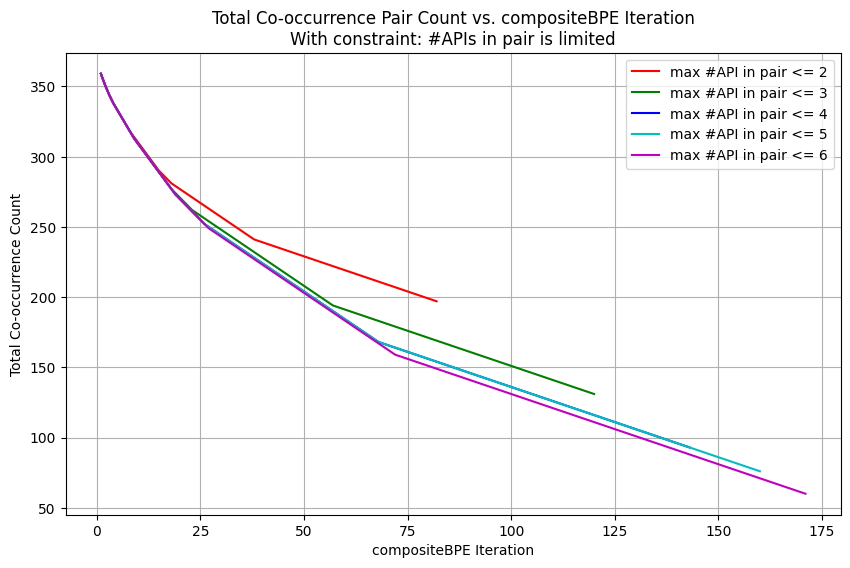

In [7]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
max_API_values = [2, 3, 4, 5, 6]
color_list = ['r', 'g', 'b', 'c', 'm']

for max_API, color in zip(max_API_values, color_list):
    with open("sample.txt", "r") as file:
        lines = [line.strip().split(" ") for line in file]
    merged_pairs_list, total_count_iter, lines = self_BPE(lines, num_iterations, max_API)
    plt.plot(range(1, len(total_count_iter) + 1), total_count_iter, color=color, label=f"max #API in pair <= {max_API}")
plt.title(f"Total Co-occurrence Pair Count vs. compositeBPE Iteration\nWith constraint: #APIs in pair is limited")
plt.xlabel("compositeBPE Iteration")
plt.ylabel("Total Co-occurrence Count")
plt.grid(True)
plt.legend()
plt.savefig(f'Total_Co-occurrenceCount_compositeBPE_Iteration.png')
plt.show()


####  Conclusion: From the slope of curve, when #API maximum limit is losen, more API pair can be included.

### step5: Case study. Whether this method is reasonable

In [36]:
max_API_merge=2

In [37]:
# rerun for analysis
with open("sample.txt", "r") as file:
    lines = [line.strip().split(" ") for line in file]
merged_pairs_list, total_count_iter, lines = self_BPE(lines, num_iterations, max_API_merge)

No valid pair to merge. Ending at iteration 82.


####  Metric1: How much tl, pl pair are recognized?

In [38]:
def count_same_function_name_pairs(pairs_list):
    """
    Count pairs where the last part of the API names (function names) are the same.
    """
    count = 0
    result = []
    for pair in pairs_list:
        # Split each API name by '.' and compare the last elements
        first_api, second_api = pair
        if first_api.split('.')[-1] == second_api.split('.')[-1]:
            if 'tl' in first_api and 'pl' in second_api:
                count += 1
                result.append(pair)
    return count,result

same_function_name_count,same_function_name_pair = count_same_function_name_pairs(merged_pairs_list)
same_function_name_count, same_function_name_pair

(3,
 [['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups'],
  ['scanpy.tl.paga', 'scanpy.pl.paga'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.draw_graph']])

In [39]:
# how much tl-pl pair appear in text?
with open("sample.txt", "r") as file:
    initial_lines = [line.strip().split(" ") for line in file]
co_occurrences = count_co_occurrences(initial_lines)
count_same_function_name_pairs([i.split('+') for i in list(co_occurrences.keys())])

(7,
 [['scanpy.tl.umap', 'scanpy.pl.umap'],
  ['scanpy.tl.embedding_density', 'scanpy.pl.embedding_density'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.draw_graph'],
  ['scanpy.tl.paga', 'scanpy.pl.paga'],
  ['scanpy.tl.pca', 'scanpy.pl.pca'],
  ['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups'],
  ['scanpy.tl.dendrogram', 'scanpy.pl.dendrogram']])

#### Metric2: How much tl, pl pair are recognized? With different func name

In [40]:
def count_tlpl_function_name_pairs(pairs_list):
    """
    Count pairs with tl, pl as pairs
    """
    count = 0
    result = []
    for pair in pairs_list:
        # Split each API name by '.' and compare the last elements
        first_api, second_api = pair
        if 'tl' in first_api and 'pl' in second_api:
            count += 1
            result.append(pair)
    return count,result

same_function_name_count,same_function_name_pair = count_tlpl_function_name_pairs(merged_pairs_list)
same_function_name_count, same_function_name_pair

(5,
 [['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups'],
  ['scanpy.tl.leiden', 'scanpy.pl.umap'],
  ['scanpy.tl.paga', 'scanpy.pl.paga'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.draw_graph'],
  ['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups_dotplot']])

In [41]:
# how much tl-pl pair appear in text?
count_tlpl_function_name_pairs([i.split('+') for i in list(co_occurrences.keys())])

(21,
 [['scanpy.tl.umap', 'scanpy.pl.umap'],
  ['scanpy.tl.ingest', 'scanpy.pl.umap'],
  ['scanpy.tl.embedding_density', 'scanpy.pl.embedding_density'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.draw_graph'],
  ['scanpy.tl.paga', 'scanpy.pl.paga'],
  ['scanpy.tl.pca', 'scanpy.pl.pca'],
  ['scanpy.tl.leiden', 'scanpy.pl.umap'],
  ['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups'],
  ['scanpy.tl.leiden', 'scanpy.pl.tsne'],
  ['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups_dotplot'],
  ['scanpy.tl.dendrogram', 'scanpy.pl.dendrogram'],
  ['scanpy.tl.score_genes', 'scanpy.pl.umap'],
  ['scanpy.tl.louvain', 'scanpy.pl.umap'],
  ['scanpy.tl.paga', 'scanpy.pl.paga_compare'],
  ['scanpy.tl.dpt', 'scanpy.pl.umap'],
  ['scanpy.tl.paga', 'scanpy.pl.paga_path'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.pca_scatter'],
  ['scanpy.tl.score_genes_cell_cycle', 'scanpy.pl.umap'],
  ['scanpy.tl.rank_genes_groups', 'scanpy.pl.umap'],
  ['scanpy.tl.louvain', 'scanpy.pl.rank_genes_groups_vi

#### Metric3: How much same func name pair are recognized, without tl-pl alignment

In [42]:
def count_same_function_name(pairs_list):
    """
    Count pairs with same name, no need for tl-pl pair
    """
    count = 0
    result = []
    for pair in pairs_list:
        # Split each API name by '.' and compare the last elements
        first_api, second_api = pair
        if first_api.split('.')[-1] == second_api.split('.')[-1] and first_api!=second_api:
            count += 1
            result.append(pair)
    return count,result

same_function_name_count,same_function_name_pair = count_same_function_name(merged_pairs_list)
same_function_name_count, same_function_name_pair

(4,
 [['scanpy.tl.rank_genes_groups', 'scanpy.pl.rank_genes_groups'],
  ['scanpy.tl.paga', 'scanpy.pl.paga'],
  ['scanpy.tl.draw_graph', 'scanpy.pl.draw_graph'],
  ['scanpy.pl.umap', 'scanpy.tl.umap']])

In [43]:
# how much same name pair appear in text?
same_function_name_count, same_function_name_pair = count_same_function_name([i.split('+') for i in list(co_occurrences.keys())])
# ignore the order in pair
same_function_name_pair = [set(i) for i in same_function_name_pair]
unique_tuples = set(tuple(sorted(item)) for item in same_function_name_pair)
unique_sets = [set(item) for item in unique_tuples]
unique_sets

[{'scanpy.pl.draw_graph', 'scanpy.tl.draw_graph'},
 {'scanpy.pl.paga', 'scanpy.tl.paga'},
 {'scanpy.pl.pca', 'scanpy.tl.pca'},
 {'scanpy.pl.embedding_density', 'scanpy.tl.embedding_density'},
 {'scanpy.pl.dendrogram', 'scanpy.tl.dendrogram'},
 {'scanpy.pl.umap', 'scanpy.tl.umap'},
 {'scanpy.pl.rank_genes_groups', 'scanpy.tl.rank_genes_groups'},
 {'scanpy.pl.highly_variable_genes', 'scanpy.pp.highly_variable_genes'}]

#### Conclusion: When checking the tl-pl pair (as this rule is obvious), BPE can recognize only part of the pairs.